In [3]:
import string
import torch
import numpy as np
import torch.nn as nn
import os
import argparse
import zipfile
import wget
import time
import pickle
import fnmatch
import json
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset,DataLoader


In [4]:
def download(url, targetdir):
    """下载"""
    print("* Downloading data from {}...".format(url))
    filepath = os.path.join(targetdir, url.split('/')[-1])
    wget.download(url, filepath)
    return filepath


def unzip(filepath):
    """解压"""
    print("\n* Extracting: {}...".format(filepath))
    dirpath = os.path.dirname(filepath)
    with zipfile.ZipFile(filepath) as zf:
        for name in zf.namelist():
            if "__MACOSX" in name or\
               ".DS_Store" in name or\
               "Icon" in name:
                continue
            zf.extract(name, dirpath)
    os.remove(filepath)


def download_unzip(url, targetdir):
    filepath = os.path.join(targetdir, url.split('/')[-1])
    target = os.path.join(targetdir,
                          ".".join((url.split('/')[-1]).split('.')[:-1]))

    if not os.path.exists(targetdir):
        print("* Creating target directory {}...".format(targetdir))
        os.makedirs(targetdir)

    # 发现解压文件，跳过下载和解压
    if os.path.exists(target) or os.path.exists(target + ".txt"):
        print("* Found unzipped data in {}, skipping download and unzip..."
              .format(targetdir))
    # 发现压缩文件，跳过下载
    elif os.path.exists(filepath):
        print("* Found zipped data in {} - skipping download..."
              .format(targetdir))
        unzip(filepath)
    # 下载 & 解压
    else:
        unzip(download(url, targetdir))

In [8]:
# 相应的URL
dataset_url = "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
embeddings_url = "http://www-nlp.stanford.edu/data/glove.840B.300d.zip"

target_dir = "data_task3"

print(30*"=", "Fetching the dataset:", 30*'=')
download_unzip(dataset_url, os.path.join(target_dir, "dataset"))

print(30*"=", "Fetching the word embeddings:", 30*"=")
download_unzip(embeddings_url, os.path.join(target_dir, "embeddings"))

============================== Fetching the dataset: ==============================
* Found unzipped data in data_task3/dataset, skipping download and unzip...
============================== Fetching the word embeddings: ==============================
* Found unzipped data in data_task3/embeddings, skipping download and unzip...


In [9]:
class Preprocessor(object):
    ''' 预处理类 '''
    def __init__(self, lowercase=False, ignore_punctuation=False, num_words=None, 
                 stopwords=[], labeldict={}, bos=None, eos=None):
        """
        Args:
            lowercase:是否转换为小写，默认否
            ignore_punctuation: 是否忽略标点符号，默认否
            num_words: worddict中使用的词数量，默认None表示全部
            stopwords: 构建worddict时的停用词表，默认为空
            bos: 句子起始 默认None
            eos: 句子结尾 默认None
        """
        self.lowercase = lowercase
        self.ignore_punctuation = ignore_punctuation
        self.num_words = num_words
        self.stopwords = stopwords
        self.labeldict = labeldict
        self.bos = bos
        self.eos = eos

    def read_data(self, filepath):
        """
        从NLI数据集读取ids，premises，hypotheses，labels，返回相应字典
        """
        with open(filepath, "r", encoding="utf8") as input_data:
            ids, premises, hypotheses, labels = [], [], [], []

            # 括号和标点符号的替换方式
            parentheses_table = str.maketrans({"(": None, ")": None})
            punct_table = str.maketrans({key: " " for key in string.punctuation})

            # 忽略文件首行
            next(input_data)

            # 处理每行
            for line in input_data:
                line = line.strip().split("\t")

                # 忽略无标签句子
                if line[0] == "-":
                    continue

                pair_id = line[7] # captionID?
                premise = line[1]
                hypothesis = line[2]

                # 移除括号
                premise = premise.translate(parentheses_table)
                hypothesis = hypothesis.translate(parentheses_table)

                if self.lowercase:
                    premise = premise.lower()
                    hypothesis = hypothesis.lower()

                if self.ignore_punctuation:
                    premise = premise.translate(punct_table)
                    hypothesis = hypothesis.translate(punct_table)

                # 将句子分成词列表
                premises.append([w for w in premise.rstrip().split()
                                 if w not in self.stopwords])
                hypotheses.append([w for w in hypothesis.rstrip().split()
                                   if w not in self.stopwords])
                labels.append(line[0])
                ids.append(pair_id)

            return {"ids": ids,
                    "premises": premises,
                    "hypotheses": hypotheses,
                    "labels": labels}

    def build_worddict(self, data):
        """
        构建词典（词-索引）
        Args:
            data: read_data所返回dict
        """
        words = []
        [words.extend(sentence) for sentence in data["premises"]]
        [words.extend(sentence) for sentence in data["hypotheses"]]

        counts = Counter(words)
        num_words = self.num_words
        if self.num_words is None:
            num_words = len(counts)

        self.worddict = {}

        # 索引0 -- padding
        # 索引1 -- out-of-vocabulary words
        # 索引2 -- beginning of sentence
        # 索引3 -- end of sentence
        self.worddict["_PAD_"] = 0
        self.worddict["_OOV_"] = 1

        offset = 2
        if self.bos:
            self.worddict["_BOS_"] = 2
            offset += 1
        if self.eos:
            self.worddict["_EOS_"] = 3
            offset += 1

        for i, word in enumerate(counts.most_common(num_words)):
            self.worddict[word[0]] = i + offset

        if self.labeldict == {}:
            label_names = set(data["labels"])
            self.labeldict = {label_name: i
                              for i, label_name in enumerate(label_names)}

    def words_to_indices(self, sentence):
        """
        将句子中词转换为词典中对应的索引
        Args:
            sentence: 词列表
        Returns:
            索引列表
        """
        indices = []

        # BOS
        if self.bos:
            indices.append(self.worddict["_BOS_"])

        for word in sentence:
            if word in self.worddict:
                index = self.worddict[word]
            else:

                # out-of-vocabulary word (OOV).
                index = self.worddict["_OOV_"]
            indices.append(index)

        # EOS
        if self.eos:
            indices.append(self.worddict["_EOS_"])

        return indices

    def indices_to_words(self, indices):
        """
        将索引转换为词
        """
        return [list(self.worddict.keys())[list(self.worddict.values())
                                           .index(i)]
                for i in indices]

    def transform_to_indices(self, data):
        """
        将premises和hypotheses，labels转换为索引
        Args:
            data: read_data返回的dict
        Returns:
            包含转换后premises, hypotheses,labels的dict.
        """
        transformed_data = {"ids": [],
                            "premises": [],
                            "hypotheses": [],
                            "labels": []}

        for i, premise in enumerate(data["premises"]):
            # Ignore sentences that have a label for which no index was
            # defined in 'labeldict'.
            label = data["labels"][i]
            if label not in self.labeldict and label != "hidden":
                continue

            transformed_data["ids"].append(data["ids"][i])

            if label == "hidden":
                transformed_data["labels"].append(-1)
            else:
                transformed_data["labels"].append(self.labeldict[label])

            indices = self.words_to_indices(premise)
            transformed_data["premises"].append(indices)

            indices = self.words_to_indices(data["hypotheses"][i])
            transformed_data["hypotheses"].append(indices)

        return transformed_data

    def build_embedding_matrix(self, embeddings_file):
        """
        为当前词典创建预训练词向量矩阵
        Args:
            embeddings_file: 预训练词向量
        Returns:
            numpy矩阵 -- 大小(num_words + n_special_tokens, embedding_dim)
            n_special_tokens: padding/oov/bos/eos
        """
        # 加载词向量
        embeddings = {}
        with open(embeddings_file, "r", encoding="utf8") as input_data:
            for line in input_data:
                line = line.split()

                try:
                    # 检查是否为词向量数据
                    float(line[1])
                    word = line[0]
                    if word in self.worddict:
                        embeddings[word] = line[1:]

                # 忽略无用行
                except ValueError:
                    continue

        num_words = len(self.worddict)
        embedding_dim = len(list(embeddings.values())[0])
        embedding_matrix = np.zeros((num_words, embedding_dim))

        # 构建矩阵
        missed = 0
        for word, i in self.worddict.items():
            if word in embeddings:
                embedding_matrix[i] = np.array(embeddings[word], dtype=float)
            else:
                if word == "_PAD_":
                    continue
                missed += 1
                # oov词高斯随机初始化
                embedding_matrix[i] = np.random.normal(size=(embedding_dim))
        print("Missed words: ", missed)

        return embedding_matrix

In [10]:
"""
预处理数据集和词向量
"""
def preprocess_SNLI_data(inputdir, embeddings_file, targetdir, lowercase=False, ignore_punctuation=False,
                         num_words=None, stopwords=[], labeldict={}, bos=None, eos=None):

    if not os.path.exists(targetdir):
        os.makedirs(targetdir)

    # 获取训练，验证，测试文件
    train_file = ""
    dev_file = ""
    test_file = ""
    for file in os.listdir(inputdir):
        if fnmatch.fnmatch(file, "*_train.txt"):
            train_file = file
        elif fnmatch.fnmatch(file, "*_dev.txt"):
            dev_file = file
        elif fnmatch.fnmatch(file, "*_test.txt"):
            test_file = file

    # ------------------------- 训练数据集预处理 -------------------------- #
    preprocessor = Preprocessor(lowercase=lowercase, ignore_punctuation=ignore_punctuation,
                                num_words=num_words, stopwords=stopwords,
                                labeldict=labeldict, bos=bos, eos=eos)

    print(30*"=", " Preprocessing train set ", 30*"=")
    print("\t* Reading data...")
    data = preprocessor.read_data(os.path.join(inputdir, train_file))

    print("\t* Computing worddict and saving it...")
    preprocessor.build_worddict(data)
    with open(os.path.join(targetdir, "worddict.pkl"), "wb") as pkl_file:
        pickle.dump(preprocessor.worddict, pkl_file)

    print("\t* Transforming words in premises and hypotheses to indices...")
    transformed_data = preprocessor.transform_to_indices(data)
    print("\t* Saving result...")
    with open(os.path.join(targetdir, "train_data.pkl"), "wb") as pkl_file:
        pickle.dump(transformed_data, pkl_file)

    # ------------------------ 验证数据集预处理 --------------------------- #
    print(30*"=", " Preprocessing dev set ", 30*"=")
    print("\t* Reading data...")
    data = preprocessor.read_data(os.path.join(inputdir, dev_file))

    print("\t* Transforming words in premises and hypotheses to indices...")
    transformed_data = preprocessor.transform_to_indices(data)
    print("\t* Saving result...")
    with open(os.path.join(targetdir, "dev_data.pkl"), "wb") as pkl_file:
        pickle.dump(transformed_data, pkl_file)

    # ------------------------ 测试数据集预处理 --------------------------- #
    print(30*"=", " Preprocessing test set ", 30*"=")
    print("\t* Reading data...")
    data = preprocessor.read_data(os.path.join(inputdir, test_file))

    print("\t* Transforming words in premises and hypotheses to indices...")
    transformed_data = preprocessor.transform_to_indices(data)
    print("\t* Saving result...")
    with open(os.path.join(targetdir, "test_data.pkl"), "wb") as pkl_file:
        pickle.dump(transformed_data, pkl_file)

    # ------------------------ 词向量预处理 ----------------------------- #
    print(30*"=", " Preprocessing embeddings ", 30*"=")
    print("\t* Building embedding matrix and saving it...")
    embed_matrix = preprocessor.build_embedding_matrix(embeddings_file)
    with open(os.path.join(targetdir, "embeddings.pkl"), "wb") as pkl_file:
        pickle.dump(embed_matrix, pkl_file)



In [14]:
default_config = "config/snli_preprocessing.json" # 配置文件

with open(default_config, "r") as cfg_file:
    config = json.load(cfg_file)

### 数据预处理 
preprocess_SNLI_data(
    os.path.normpath(config["data_dir"]), # "data_task3/dataset/snli_1.0"
    os.path.normpath(config["embeddings_file"]), # "data_task3/embeddings/glove.840B.300d.txt",
    os.path.normpath(config["target_dir"]), # "data_task3/preprocessed/SNLI"
    lowercase=config["lowercase"], # false
    ignore_punctuation=config["ignore_punctuation"], # false
    num_words=config["num_words"], # None
    stopwords=config["stopwords"], # []
    labeldict=config["labeldict"], # {'e':0, 'n':1, 'c':2}
    bos=config["bos"], # '_BOS_'
    eos=config["eos"] # '_EOS_'
)

==============================  Preprocessing train set  ==============================
	* Reading data...
	* Computing worddict and saving it...
	* Transforming words in premises and hypotheses to indices...
	* Saving result...
==============================  Preprocessing dev set  ==============================
	* Reading data...
	* Transforming words in premises and hypotheses to indices...
	* Saving result...
==============================  Preprocessing test set  ==============================
	* Reading data...
	* Transforming words in premises and hypotheses to indices...
	* Saving result...
==============================  Preprocessing embeddings  ==============================
	* Building embedding matrix and saving it...
Missed words:  4045


In [15]:

class NLIDataset(Dataset):
    """
    Dataset类
    """

    def __init__(self, data, padding_idx=0, max_premise_length=None,
                 max_hypothesis_length=None):
        """
        Args:
            data: 包含预处理premises, hypotheses 和 labels的字典.
            padding_idx: 用于padding的索引, 默认0.
            max_premise_length: premises的最大长度. 默认None，使用data中premises最大长度.
            max_hypothesis_length: hypotheses的最大长度. 默认None，使用data中hypotheses最大长度.
        """
        self.premises_lengths = [len(seq) for seq in data["premises"]]
        self.max_premise_length = max_premise_length
        if self.max_premise_length is None:
            self.max_premise_length = max(self.premises_lengths)

        self.hypotheses_lengths = [len(seq) for seq in data["hypotheses"]]
        self.max_hypothesis_length = max_hypothesis_length
        if self.max_hypothesis_length is None:
            self.max_hypothesis_length = max(self.hypotheses_lengths)

        self.num_sequences = len(data["premises"])

        self.data = {"ids": [],
                     "premises": torch.ones((self.num_sequences,
                                             self.max_premise_length),
                                            dtype=torch.long) * padding_idx,
                     "hypotheses": torch.ones((self.num_sequences,
                                               self.max_hypothesis_length),
                                              dtype=torch.long) * padding_idx,
                     "labels": torch.tensor(data["labels"], dtype=torch.long)}

        for i, premise in enumerate(data["premises"]):
            self.data["ids"].append(data["ids"][i])
            end = min(len(premise), self.max_premise_length)
            self.data["premises"][i][:end] = torch.tensor(premise[:end])

            hypothesis = data["hypotheses"][i]
            end = min(len(hypothesis), self.max_hypothesis_length)
            self.data["hypotheses"][i][:end] = torch.tensor(hypothesis[:end])

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, index):
        return {"id": self.data["ids"][index],
                "premise": self.data["premises"][index],
                "premise_length": min(self.premises_lengths[index],
                                      self.max_premise_length),
                "hypothesis": self.data["hypotheses"][index],
                "hypothesis_length": min(self.hypotheses_lengths[index],
                                         self.max_hypothesis_length),
                "label": self.data["labels"][index]}

In [16]:
"""
ESIM model的工具函数
"""

def sort_by_seq_lens(batch, sequences_lengths, descending=True):
    """
    根据句子序列长度排序
    Args:
        batch: 批，大小(batch_size ，max_sequence_length ，*)
        sequences_lengths: A tensor containing the lengths of the sequences in the
            input batch. The tensor should be of size (batch_size).
        descending: A boolean value indicating whether to sort the sequences
            by their lengths in descending order. Defaults to True.
    Returns:
        sorted_batch: A tensor containing the input batch reordered by
            sequences lengths.
        sorted_seq_lens: A tensor containing the sorted lengths of the
            sequences in the input batch.
        sorting_idx: A tensor containing the indices used to permute the input
            batch in order to get 'sorted_batch'.
        restoration_idx: A tensor containing the indices that can be used to
            restore the order of the sequences in 'sorted_batch' so that it
            matches the input batch.
    """
    sorted_seq_lens, sorting_index =\
        sequences_lengths.sort(0, descending=descending)

    sorted_batch = batch.index_select(0, sorting_index)

    idx_range =\
        sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))
    _, reverse_mapping = sorting_index.sort(0, descending=False)
    restoration_index = idx_range.index_select(0, reverse_mapping)

    return sorted_batch, sorted_seq_lens, sorting_index, restoration_index


def get_mask(sequences_batch, sequences_lengths):
    """
    Get the mask for a batch of padded variable length sequences.
    Args:
        sequences_batch: A batch of padded variable length sequences
            containing word indices. Must be a 2-dimensional tensor of size
            (batch, sequence).
        sequences_lengths: A tensor containing the lengths of the sequences in
            'sequences_batch'. Must be of size (batch).
    Returns:
        A mask of size (batch, max_sequence_length), where max_sequence_length
        is the length of the longest sequence in the batch.
    """
    batch_size = sequences_batch.size()[0]
    max_length = torch.max(sequences_lengths)
    mask = torch.ones(batch_size, max_length, dtype=torch.float)
    mask[sequences_batch[:, :max_length] == 0] = 0.0
    return mask


def masked_softmax(tensor, mask):
    """
    Apply a masked softmax on the last dimension of a tensor.
    The input tensor and mask should be of size (batch, *, sequence_length).
    Args:
        tensor: The tensor on which the softmax function must be applied along
            the last dimension.
        mask: A mask of the same size as the tensor with 0s in the positions of
            the values that must be masked and 1s everywhere else.
    Returns:
        A tensor of the same size as the inputs containing the result of the
        softmax.
    """
    tensor_shape = tensor.size()
    reshaped_tensor = tensor.view(-1, tensor_shape[-1])

    # Reshape the mask so it matches the size of the input tensor.
    while mask.dim() < tensor.dim():
        mask = mask.unsqueeze(1)
    mask = mask.expand_as(tensor).contiguous().float()
    reshaped_mask = mask.view(-1, mask.size()[-1])

    result = nn.functional.softmax(reshaped_tensor * reshaped_mask, dim=-1)
    result = result * reshaped_mask
    # 1e-13 is added to avoid divisions by zero.
    result = result / (result.sum(dim=-1, keepdim=True) + 1e-13)

    return result.view(*tensor_shape)

def weighted_sum(tensor, weights, mask):
    """
    Apply a weighted sum on the vectors along the last dimension of 'tensor',
    and mask the vectors in the result with 'mask'.
    Args:
        tensor: A tensor of vectors on which a weighted sum must be applied.
        weights: The weights to use in the weighted sum.
        mask: A mask to apply on the result of the weighted sum.
    Returns:
        A new tensor containing the result of the weighted sum after the mask
        has been applied on it.
    """
    weighted_sum = weights.bmm(tensor)

    while mask.dim() < weighted_sum.dim():
        mask = mask.unsqueeze(1)
    mask = mask.transpose(-1, -2)
    mask = mask.expand_as(weighted_sum).contiguous().float()

    return weighted_sum * mask

def replace_masked(tensor, mask, value):
    """
    Replace the all the values of vectors in 'tensor' that are masked in
    'masked' by 'value'.
    Args:
        tensor: The tensor in which the masked vectors must have their values
            replaced.
        mask: A mask indicating the vectors which must have their values
            replaced.
        value: The value to place in the masked vectors of 'tensor'.
    Returns:
        A new tensor of the same size as 'tensor' where the values of the
        vectors masked in 'mask' were replaced by 'value'.
    """
    mask = mask.unsqueeze(1).transpose(2, 1)
    reverse_mask = 1.0 - mask
    values_to_add = value * reverse_mask
    return tensor * mask + values_to_add


def correct_predictions(output_probabilities, targets):
    """
    Compute the number of predictions that match some target classes in the
    output of a model.
    Args:
        output_probabilities: A tensor of probabilities for different output
            classes.
        targets: The indices of the actual target classes.
    Returns:
        The number of correct predictions in 'output_probabilities'.
    """
    _, out_classes = output_probabilities.max(dim=1)
    correct = (out_classes == targets).sum()
    return correct.item()

In [17]:
"""
Definition of custom layers for the ESIM model.
"""

class RNNDropout(nn.Dropout):
    """
    Dropout layer for the inputs of RNNs.
    Apply the same dropout mask to all the elements of the same sequence in
    a batch of sequences of size (batch, sequences_length, embedding_dim).
    """

    def forward(self, sequences_batch):
        """
        Apply dropout to the input batch of sequences.
        Args:
            sequences_batch: A batch of sequences of vectors that will serve
                as input to an RNN.
                Tensor of size (batch, sequences_length, emebdding_dim).
        Returns:
            A new tensor on which dropout has been applied.
        """
        ones = sequences_batch.data.new_ones(sequences_batch.shape[0],
                                             sequences_batch.shape[-1])
        dropout_mask = nn.functional.dropout(ones, self.p, self.training,
                                             inplace=False)
        return dropout_mask.unsqueeze(1) * sequences_batch

In [19]:
class Seq2SeqEncoder(nn.Module):
    """
    RNN taking variable length padded sequences of vectors as input and
    encoding them into padded sequences of vectors of the same length.
    This module is useful to handle batches of padded sequences of vectors
    that have different lengths and that need to be passed through a RNN.
    The sequences are sorted in descending order of their lengths, packed,
    passed through the RNN, and the resulting sequences are then padded and
    permuted back to the original order of the input sequences.
    """

    def __init__(self,
                 rnn_type,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 bias=True,
                 dropout=0.0,
                 bidirectional=False):
        """
        Args:
            rnn_type: The type of RNN to use as encoder in the module.
                Must be a class inheriting from torch.nn.RNNBase
                (such as torch.nn.LSTM for example).
            input_size: The number of expected features in the input of the
                module.
            hidden_size: The number of features in the hidden state of the RNN
                used as encoder by the module.
            num_layers: The number of recurrent layers in the encoder of the
                module. Defaults to 1.
            bias: If False, the encoder does not use bias weights b_ih and
                b_hh. Defaults to True.
            dropout: If non-zero, introduces a dropout layer on the outputs
                of each layer of the encoder except the last one, with dropout
                probability equal to 'dropout'. Defaults to 0.0.
            bidirectional: If True, the encoder of the module is bidirectional.
                Defaults to False.
        """
        assert issubclass(rnn_type, nn.RNNBase),\
            "rnn_type must be a class inheriting from torch.nn.RNNBase"

        super(Seq2SeqEncoder, self).__init__()

        self.rnn_type = rnn_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.dropout = dropout
        self.bidirectional = bidirectional

        self._encoder = rnn_type(input_size,
                                 hidden_size,
                                 num_layers=num_layers,
                                 bias=bias,
                                 batch_first=True,
                                 dropout=dropout,
                                 bidirectional=bidirectional)

    def forward(self, sequences_batch, sequences_lengths):
        """
        Args:
            sequences_batch: A batch of variable length sequences of vectors.
                The batch is assumed to be of size
                (batch, sequence, vector_dim).
            sequences_lengths: A 1D tensor containing the sizes of the
                sequences in the input batch.
        Returns:
            reordered_outputs: The outputs (hidden states) of the encoder for
                the sequences in the input batch, in the same order.
        """
        sorted_batch, sorted_lengths, _, restoration_idx =\
            sort_by_seq_lens(sequences_batch, sequences_lengths)
        packed_batch = nn.utils.rnn.pack_padded_sequence(sorted_batch,
                                                         sorted_lengths,
                                                         batch_first=True)

        outputs, _ = self._encoder(packed_batch, None)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs,
                                                      batch_first=True)
        reordered_outputs = outputs.index_select(0, restoration_idx)

        return reordered_outputs

In [20]:
class SoftmaxAttention(nn.Module):
    """
    Attention layer taking premises and hypotheses encoded by an RNN as input
    and computing the soft attention between their elements.
    The dot product of the encoded vectors in the premises and hypotheses is
    first computed. The softmax of the result is then used in a weighted sum
    of the vectors of the premises for each element of the hypotheses, and
    conversely for the elements of the premises.
    """

    def forward(self,
                premise_batch,
                premise_mask,
                hypothesis_batch,
                hypothesis_mask):
        """
        Args:
            premise_batch: A batch of sequences of vectors representing the
                premises in some NLI task. The batch is assumed to have the
                size (batch, sequences, vector_dim).
            premise_mask: A mask for the sequences in the premise batch, to
                ignore padding data in the sequences during the computation of
                the attention.
            hypothesis_batch: A batch of sequences of vectors representing the
                hypotheses in some NLI task. The batch is assumed to have the
                size (batch, sequences, vector_dim).
            hypothesis_mask: A mask for the sequences in the hypotheses batch,
                to ignore padding data in the sequences during the computation
                of the attention.
        Returns:
            attended_premises: The sequences of attention vectors for the
                premises in the input batch.
            attended_hypotheses: The sequences of attention vectors for the
                hypotheses in the input batch.
        """
        # Dot product between premises and hypotheses in each sequence of
        # the batch.
        similarity_matrix = premise_batch.bmm(hypothesis_batch.transpose(2, 1)
                                                              .contiguous())

        # Softmax attention weights.
        prem_hyp_attn = masked_softmax(similarity_matrix, hypothesis_mask)
        hyp_prem_attn = masked_softmax(similarity_matrix.transpose(1, 2)
                                                        .contiguous(),
                                       premise_mask)

        # Weighted sums of the hypotheses for the the premises attention,
        # and vice-versa for the attention of the hypotheses.
        attended_premises = weighted_sum(hypothesis_batch,
                                         prem_hyp_attn,
                                         premise_mask)
        attended_hypotheses = weighted_sum(premise_batch,
                                           hyp_prem_attn,
                                           hypothesis_mask)

        return attended_premises, attended_hypotheses

In [21]:
def _init_esim_weights(module):
    """
    Initialization for ESIM
    """
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data)
        nn.init.constant_(module.bias.data, 0.0)

    elif isinstance(module, nn.LSTM):
        nn.init.xavier_uniform_(module.weight_ih_l0.data)
        nn.init.orthogonal_(module.weight_hh_l0.data)
        nn.init.constant_(module.bias_ih_l0.data, 0.0)
        nn.init.constant_(module.bias_hh_l0.data, 0.0)
        hidden_size = module.bias_hh_l0.data.shape[0] // 4
        module.bias_hh_l0.data[hidden_size:(2*hidden_size)] = 1.0

        if (module.bidirectional):
            nn.init.xavier_uniform_(module.weight_ih_l0_reverse.data)
            nn.init.orthogonal_(module.weight_hh_l0_reverse.data)
            nn.init.constant_(module.bias_ih_l0_reverse.data, 0.0)
            nn.init.constant_(module.bias_hh_l0_reverse.data, 0.0)
            module.bias_hh_l0_reverse.data[hidden_size:(2*hidden_size)] = 1.0

In [22]:
class ESIM(nn.Module):
    """
    ESIM model
    """

    def __init__(self, vocab_size, embedding_dim, hidden_size, embeddings=None,
                 padding_idx=0, dropout=0.5, num_classes=3, device="cpu"):
        """
        Args:
            vocab_size: 词表大小
            embedding_dim: 词向量维度
            hidden_size: 隐藏层大小
            embeddings: 词向量，大小为(vocab_size, embedding_dim)，默认None表示随机初始化
            padding_idx: padding index，默认0
            dropout: dropout rate，默认0.5
            num_classes: 输出类别数，默认为3:E/N/C
            device: model运行的设备，默认cpu
        """
        super(ESIM, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.dropout = dropout
        self.device = device
        
        # =========================== Input Encoding ============================
        # Embedding
        self._word_embedding = nn.Embedding(self.vocab_size,
                                            self.embedding_dim,
                                            padding_idx=padding_idx,
                                            _weight=embeddings)
        # Dropout
        if self.dropout:
            self._rnn_dropout = RNNDropout(p=self.dropout)
            # self._rnn_dropout = nn.Dropout(p=self.dropout)
        
        # biLSTM
        self._encoding = Seq2SeqEncoder(nn.LSTM,
                                        self.embedding_dim,
                                        self.hidden_size,
                                        bidirectional=True)
        
        # ========================== Local inference modeling =====================
        # Attention
        self._attention = SoftmaxAttention()

        # Projection
        self._projection = nn.Sequential(nn.Linear(4*2*self.hidden_size,
                                                   self.hidden_size),
                                         nn.ReLU())
        
        # ========================== inference composition ========================
        # biLSTM
        self._composition = Seq2SeqEncoder(nn.LSTM,
                                           self.hidden_size,
                                           self.hidden_size,
                                           bidirectional=True)
        # Prediction
        self._classification = nn.Sequential(nn.Dropout(p=self.dropout),
                                             nn.Linear(2*4*self.hidden_size,
                                                       self.hidden_size),
                                             nn.Tanh(),
                                             nn.Dropout(p=self.dropout),
                                             nn.Linear(self.hidden_size,
                                                       self.num_classes))

        # Initialization
        self.apply(_init_esim_weights)

    def forward(self, premises, premises_lengths, hypotheses, hypotheses_lengths):
        """
        Args:
            premises: (batch, premises_length).
            premises_lengths: 'premises'中句子的长度.
            hypothesis: A batch of varaible length sequences of word indices
                representing hypotheses. The batch is assumed to be of size
                (batch, hypotheses_length).
            hypotheses_lengths: A 1D tensor containing the lengths of the
                hypotheses in 'hypotheses'.
        Returns:
            logits: A tensor of size (batch, num_classes) containing the
                logits for each output class of the model.
            probabilities: A tensor of size (batch, num_classes) containing
                the probabilities of each output class in the model.
        """
        premises_mask = get_mask(premises, premises_lengths).to(self.device)
        hypotheses_mask = get_mask(hypotheses, hypotheses_lengths)\
            .to(self.device)

        embedded_premises = self._word_embedding(premises)
        embedded_hypotheses = self._word_embedding(hypotheses)

        if self.dropout:
            embedded_premises = self._rnn_dropout(embedded_premises)
            embedded_hypotheses = self._rnn_dropout(embedded_hypotheses)

        encoded_premises = self._encoding(embedded_premises,
                                          premises_lengths)
        encoded_hypotheses = self._encoding(embedded_hypotheses,
                                            hypotheses_lengths)

        attended_premises, attended_hypotheses =\
            self._attention(encoded_premises, premises_mask,
                            encoded_hypotheses, hypotheses_mask)

        enhanced_premises = torch.cat([encoded_premises,
                                       attended_premises,
                                       encoded_premises - attended_premises,
                                       encoded_premises * attended_premises],
                                      dim=-1)
        enhanced_hypotheses = torch.cat([encoded_hypotheses,
                                         attended_hypotheses,
                                         encoded_hypotheses -
                                         attended_hypotheses,
                                         encoded_hypotheses *
                                         attended_hypotheses],
                                        dim=-1)

        projected_premises = self._projection(enhanced_premises)
        projected_hypotheses = self._projection(enhanced_hypotheses)

        if self.dropout:
            projected_premises = self._rnn_dropout(projected_premises)
            projected_hypotheses = self._rnn_dropout(projected_hypotheses)

        v_ai = self._composition(projected_premises, premises_lengths)
        v_bj = self._composition(projected_hypotheses, hypotheses_lengths)

        v_a_avg = torch.sum(v_ai * premises_mask.unsqueeze(1)
                                                .transpose(2, 1), dim=1)\
            / torch.sum(premises_mask, dim=1, keepdim=True)
        v_b_avg = torch.sum(v_bj * hypotheses_mask.unsqueeze(1)
                                                  .transpose(2, 1), dim=1)\
            / torch.sum(hypotheses_mask, dim=1, keepdim=True)

        v_a_max, _ = replace_masked(v_ai, premises_mask, -1e7).max(dim=1)
        v_b_max, _ = replace_masked(v_bj, hypotheses_mask, -1e7).max(dim=1)

        v = torch.cat([v_a_avg, v_a_max, v_b_avg, v_b_max], dim=1)

        logits = self._classification(v)
        probabilities = nn.functional.softmax(logits, dim=-1)

        return logits, probabilities

In [23]:
def train(model, dataloader, optimizer,
          criterion, epoch_number, max_gradient_norm):
    """
    训练
    """
    model.train()
    device = model.device

    epoch_start = time.time()
    batch_time_avg = 0.0
    running_loss = 0.0
    correct_preds = 0

    tqdm_batch_iterator = tqdm(dataloader)
    for batch_index, batch in enumerate(tqdm_batch_iterator):
        batch_start = time.time()

        premises = batch["premise"].to(device)
        premises_lengths = batch["premise_length"].to(device)
        hypotheses = batch["hypothesis"].to(device)
        hypotheses_lengths = batch["hypothesis_length"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        logits, probs = model(premises,
                              premises_lengths,
                              hypotheses,
                              hypotheses_lengths)
        loss = criterion(logits, labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
        optimizer.step()

        batch_time_avg += time.time() - batch_start
        running_loss += loss.item()
        correct_preds += correct_predictions(probs, labels)

        description = "Avg. batch proc. time: {:.4f}s, loss: {:.4f}"\
                      .format(batch_time_avg/(batch_index+1),
                              running_loss/(batch_index+1))
        tqdm_batch_iterator.set_description(description)
        
    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_preds / len(dataloader.dataset)

    return epoch_time, epoch_loss, epoch_accuracy


def validate(model, dataloader, criterion):
    """
    验证
    """
    model.eval()
    device = model.device

    epoch_start = time.time()
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        for batch in dataloader:
            premises = batch["premise"].to(device)
            premises_lengths = batch["premise_length"].to(device)
            hypotheses = batch["hypothesis"].to(device)
            hypotheses_lengths = batch["hypothesis_length"].to(device)
            labels = batch["label"].to(device)

            logits, probs = model(premises,
                                  premises_lengths,
                                  hypotheses,
                                  hypotheses_lengths)
            loss = criterion(logits, labels)

            running_loss += loss.item()
            running_accuracy += correct_predictions(probs, labels)

    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / (len(dataloader.dataset))

    return epoch_time, epoch_loss, epoch_accuracy

In [24]:
"""
在处理过的snli数据集上进行训练
"""
def main(train_file, valid_file, embeddings_file, target_dir, hidden_size=300,
         dropout=0.5, num_classes=3, epochs=64, batch_size=32, lr=0.0004,
         patience=5, max_grad_norm=10.0, checkpoint=None):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(30 * "=", " Preparing for training ", 30 * "=")

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # -------------------- 数据加载 ------------------- #
    print("\t* Loading training data...")
    with open(train_file, "rb") as pkl:
        train_data = NLIDataset(pickle.load(pkl))

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    print("\t* Loading validation data...")
    with open(valid_file, "rb") as pkl:
        valid_data = NLIDataset(pickle.load(pkl))

    valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

    # -------------------- 模型构建 ------------------- #
    print("\t* Building model...")
    with open(embeddings_file, "rb") as pkl:
        embeddings = torch.tensor(pickle.load(pkl), dtype=torch.float)\
                     .to(device)

    model = ESIM(embeddings.shape[0],
                 embeddings.shape[1],
                 hidden_size,
                 embeddings=embeddings,
                 dropout=dropout,
                 num_classes=num_classes,
                 device=device).to(device)

    # -------------------- 准备训练  ------------------- #
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           mode="max",
                                                           factor=0.5,
                                                           patience=0)

    best_score = 0.0
    start_epoch = 1

    # 损失曲线数据list
    epochs_count = []
    train_losses = []
    valid_losses = []

    # 从给定checkpoint继续训练
    if checkpoint:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint["epoch"] + 1
        best_score = checkpoint["best_score"]

        print("\t* Training will continue on existing model from epoch {}..."
              .format(start_epoch))

        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        epochs_count = checkpoint["epochs_count"]
        train_losses = checkpoint["train_losses"]
        valid_losses = checkpoint["valid_losses"]

    # 计算训练开始前的损失和精度
    _, valid_loss, valid_accuracy = validate(model,
                                             valid_loader,
                                             criterion)
    print("\t* Validation loss before training: {:.4f}, accuracy: {:.4f}%"
          .format(valid_loss, (valid_accuracy*100)))

    # -------------------- 迭代 ------------------- #
    print("\n", 30 * "=","Training ESIM model on device: {}".format(device),
          30 * "=")

    patience_counter = 0
    for epoch in range(start_epoch, epochs+1):
        epochs_count.append(epoch)

        print("* Training epoch {}:".format(epoch))
        epoch_time, epoch_loss, epoch_accuracy = train(model,
                                                       train_loader,
                                                       optimizer,
                                                       criterion,
                                                       epoch,
                                                       max_grad_norm)

        train_losses.append(epoch_loss)
        print("-> Training time: {:.4f}s, loss = {:.4f}, accuracy: {:.4f}%"
              .format(epoch_time, epoch_loss, (epoch_accuracy*100)))

        print("* Validation for epoch {}:".format(epoch))
        epoch_time, epoch_loss, epoch_accuracy = validate(model,
                                                          valid_loader,
                                                          criterion)

        valid_losses.append(epoch_loss)
        print("-> Valid. time: {:.4f}s, loss: {:.4f}, accuracy: {:.4f}%\n"
              .format(epoch_time, epoch_loss, (epoch_accuracy*100)))

        # 更新学习率
        scheduler.step(epoch_accuracy)

        # Early stopping on validation accuracy.
        if epoch_accuracy < best_score:
            patience_counter += 1
        else:
            best_score = epoch_accuracy
            patience_counter = 0
            
            # 保存最优模型
            torch.save({"epoch": epoch,
                        "model": model.state_dict(),
                        "best_score": best_score,
                        "epochs_count": epochs_count,
                        "train_losses": train_losses,
                        "valid_losses": valid_losses},
                       os.path.join(target_dir, "best.pth.tar"))

        # 每轮保存模型
        torch.save({"epoch": epoch,
                    "model": model.state_dict(),
                    "best_score": best_score,
                    "optimizer": optimizer.state_dict(),
                    "epochs_count": epochs_count,
                    "train_losses": train_losses,
                    "valid_losses": valid_losses},
                   os.path.join(target_dir, "esim_{}.pth.tar".format(epoch)))

        if patience_counter >= patience:
            print("-> Early stopping: patience limit reached, stopping...")
            break

    # 损失曲线
    plt.figure()
    plt.plot(epochs_count, train_losses, "-r")
    plt.plot(epochs_count, valid_losses, "-b")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training loss", "Validation loss"])
    plt.title("Cross entropy loss")
    plt.show()


==============================  Preparing for training  ==============================
	* Loading training data...
	* Loading validation data...
	* Building model...


/home/xiyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
Avg. batch proc. time: 0.0584s, loss: 1.1730:   0%|          | 2/17168 [00:00<21:29, 13.31it/s]

	* Validation loss before training: 1.0987, accuracy: 34.6779%

 ============================== Training ESIM model on device: cuda:0 ==============================
* Training epoch 1:


Avg. batch proc. time: 0.0631s, loss: 0.6483: 100%|██████████| 17168/17168 [18:52<00:00, 15.16it/s]


-> Training time: 1132.8233s, loss = 0.6483, accuracy: 72.8036%
* Validation for epoch 1:
-> Valid. time: 9.3556s, loss: 0.4328, accuracy: 83.6822%



Avg. batch proc. time: 0.0939s, loss: 0.4907:   0%|          | 1/17168 [00:00<34:40,  8.25it/s]

* Training epoch 2:


Avg. batch proc. time: 0.0831s, loss: 0.4855: 100%|██████████| 17168/17168 [24:53<00:00, 11.49it/s]


-> Training time: 1493.9665s, loss = 0.4855, accuracy: 81.0901%
* Validation for epoch 2:
-> Valid. time: 4.9777s, loss: 0.4090, accuracy: 84.6271%



Avg. batch proc. time: 0.0548s, loss: 0.4995:   0%|          | 2/17168 [00:00<19:42, 14.51it/s]

* Training epoch 3:


Avg. batch proc. time: 0.0587s, loss: 0.4384: 100%|██████████| 17168/17168 [17:33<00:00, 16.29it/s]


-> Training time: 1053.9668s, loss = 0.4384, accuracy: 83.2689%
* Validation for epoch 3:
-> Valid. time: 5.0543s, loss: 0.3697, accuracy: 86.3138%



Avg. batch proc. time: 0.0545s, loss: 0.4665:   0%|          | 2/17168 [00:00<20:28, 13.97it/s]

* Training epoch 4:


Avg. batch proc. time: 0.0592s, loss: 0.4106: 100%|██████████| 17168/17168 [17:43<00:00, 15.55it/s]


-> Training time: 1063.9419s, loss = 0.4106, accuracy: 84.5338%
* Validation for epoch 4:
-> Valid. time: 5.0329s, loss: 0.3597, accuracy: 86.6491%



Avg. batch proc. time: 0.0605s, loss: 0.4179:   0%|          | 2/17168 [00:00<21:29, 13.32it/s]

* Training epoch 5:


Avg. batch proc. time: 0.0593s, loss: 0.3906: 100%|██████████| 17168/17168 [17:44<00:00, 16.12it/s]


-> Training time: 1064.9428s, loss = 0.3906, accuracy: 85.3267%
* Validation for epoch 5:
-> Valid. time: 4.9961s, loss: 0.3474, accuracy: 87.2384%



Avg. batch proc. time: 0.0542s, loss: 0.4670:   0%|          | 2/17168 [00:00<19:59, 14.31it/s]

* Training epoch 6:


Avg. batch proc. time: 0.0591s, loss: 0.3764: 100%|██████████| 17168/17168 [17:42<00:00, 15.77it/s]


-> Training time: 1062.0679s, loss = 0.3764, accuracy: 86.0461%
* Validation for epoch 6:
-> Valid. time: 4.9768s, loss: 0.3491, accuracy: 87.4619%



Avg. batch proc. time: 0.0557s, loss: 0.3009:   0%|          | 2/17168 [00:00<20:03, 14.26it/s]

* Training epoch 7:


Avg. batch proc. time: 0.0589s, loss: 0.3644: 100%|██████████| 17168/17168 [17:35<00:00, 15.74it/s]


-> Training time: 1055.8994s, loss = 0.3644, accuracy: 86.5487%
* Validation for epoch 7:
-> Valid. time: 4.9189s, loss: 0.3426, accuracy: 87.5635%



Avg. batch proc. time: 0.0540s, loss: 0.2842:   0%|          | 2/17168 [00:00<19:19, 14.80it/s]

* Training epoch 8:


Avg. batch proc. time: 0.0585s, loss: 0.3551: 100%|██████████| 17168/17168 [17:31<00:00, 16.05it/s]


-> Training time: 1051.4614s, loss = 0.3551, accuracy: 86.9513%
* Validation for epoch 8:
-> Valid. time: 4.9924s, loss: 0.3394, accuracy: 87.6753%



Avg. batch proc. time: 0.0573s, loss: 0.3746:   0%|          | 2/17168 [00:00<20:32, 13.93it/s]

* Training epoch 9:


Avg. batch proc. time: 0.0677s, loss: 0.3458: 100%|██████████| 17168/17168 [20:14<00:00, 14.14it/s]


-> Training time: 1214.4164s, loss = 0.3458, accuracy: 87.2506%
* Validation for epoch 9:
-> Valid. time: 7.7495s, loss: 0.3430, accuracy: 88.0817%



Avg. batch proc. time: 0.0795s, loss: 0.2143:   0%|          | 1/17168 [00:00<31:46,  9.00it/s]

* Training epoch 10:


Avg. batch proc. time: 0.0642s, loss: 0.3391: 100%|██████████| 17168/17168 [19:12<00:00, 14.90it/s]


-> Training time: 1152.4019s, loss = 0.3391, accuracy: 87.6239%
* Validation for epoch 10:
-> Valid. time: 4.9849s, loss: 0.3450, accuracy: 87.7870%



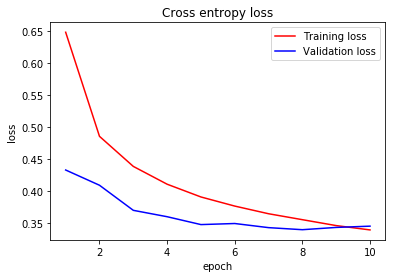

In [25]:
default_config = "config/snli_training.json" # 训练的配置文件
with open(default_config, 'r') as config_file:
    config = json.load(config_file)

    main(os.path.normpath(config["train_data"]),
         os.path.normpath(config["valid_data"]),
         os.path.normpath(config["embeddings"]),
         os.path.normpath(config["target_dir"]),
         config["hidden_size"],
         config["dropout"],
         config["num_classes"],
         config["epochs"],
         config["batch_size"],
         config["lr"],
         config["patience"],
         config["max_gradient_norm"])

In [26]:
def test(model, dataloader):
    """
    测试
    """

    model.eval()
    device = model.device

    time_start = time.time()
    batch_time = 0.0
    accuracy = 0.0


    with torch.no_grad():
        for batch in dataloader:
            batch_start = time.time()

            premises = batch["premise"].to(device)
            premises_lengths = batch["premise_length"].to(device)
            hypotheses = batch["hypothesis"].to(device)
            hypotheses_lengths = batch["hypothesis_length"].to(device)
            labels = batch["label"].to(device)

            _, probs = model(premises,
                             premises_lengths,
                             hypotheses,
                             hypotheses_lengths)

            accuracy += correct_predictions(probs, labels)
            batch_time += time.time() - batch_start

    batch_time /= len(dataloader)
    total_time = time.time() - time_start
    accuracy /= (len(dataloader.dataset))

    return batch_time, total_time, accuracy


In [27]:
# 在snli test数据集上进行测试
def main2(test_file, pretrained_file, batch_size=32):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(30 * "=", " Preparing for testing ", 30 * "=")

    checkpoint = torch.load(pretrained_file)

    vocab_size = checkpoint["model"]["_word_embedding.weight"].size(0)
    embedding_dim = checkpoint["model"]['_word_embedding.weight'].size(1)
    hidden_size = checkpoint["model"]["_projection.0.weight"].size(0)
    num_classes = checkpoint["model"]["_classification.4.weight"].size(0)

    print("\t* Loading test data...")
    with open(test_file, "rb") as pkl:
        test_data = NLIDataset(pickle.load(pkl))

    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

    print("\t* Building model...")
    model = ESIM(vocab_size,
                 embedding_dim,
                 hidden_size,
                 num_classes=num_classes,
                 device=device).to(device)

    model.load_state_dict(checkpoint["model"])

    print(30 * "=", " Testing ESIM model on device: {} ".format(device),
          30 * "=")
    batch_time, total_time, accuracy = test(model, test_loader)

    print("-> Average batch processing time: {:.4f}s, total test time:\
 {:.4f}s, accuracy: {:.4f}%".format(batch_time, total_time, (accuracy*100)))

In [28]:
# load最优模型进行测试
main2("data_task3/preprocessed/SNLI/test_data.pkl",
    "data_task3/checkpoints/SNLI/best.pth.tar")

==============================  Preparing for testing  ==============================
	* Loading test data...
	* Building model...
==============================  Testing ESIM model on device: cuda:0  ==============================


/home/xiyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).


-> Average batch processing time: 0.0106s, total test time: 3.3802s, accuracy: 86.8587%
